# Obtaining strain rates across a season at station A14

In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 
import pickle

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress
from helpers import *

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    13:14:24 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    13:14:24 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    13:14:24 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
with open('../chirp_processing/A14_22S.pickle', 'rb') as handle:
    s22 = pickle.load(handle)

with open('../chirp_processing/A14_22W.pickle', 'rb') as handle:
    winter = pickle.load(handle)

with open('../chirp_processing/A14_23S.pickle', 'rb') as handle:
    s23 = pickle.load(handle)

In [3]:
def strain_metrics(ds, win_cor, step, lag, noise_floor):
    # This function, given a window, and step, gives a total percentage of data that has high coherence
    b1 = ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    dz, co, phi = xa.generate_range_diff(b1,b2,win_cor,step,None,0,0.95)
    dz=dz.assign(coherence=(['time','profile_range'],co))
    dz_new = dz.where(abs(dz.coherence) > 0.95).drop_duplicates('time')

    vv = dz_new.range_diff / dz_new.time_diff * 31536000
    vv_err = dz_new.err / dz_new.time_diff * 31536000
    fit=vv.where(vv.profile_range <=noise_floor).polyfit('profile_range',1,full=True)
    r2 = 1-fit.polyfit_residuals/((vv.where(vv.profile_range <=noise_floor)-vv.where(vv.profile_range <=noise_floor).mean())**2).sum(dim='profile_range')
    
    slope = fit.polyfit_coefficients.sel(degree=1)*vv.profile_range+fit.polyfit_coefficients.sel(degree=0)
    residual = vv-slope
    residual = residual.where(residual.profile_range <=noise_floor,drop=True)
    slope_errs = np.sqrt((1/(len(residual.profile_range)-2))*(((residual**2).sum(dim='profile_range'))/((residual.profile_range - residual.profile_range.mean())**2).sum()))

    return np.count_nonzero(abs(co)>0.95)/np.count_nonzero(co),np.mean(r2).values,[vv,vv_err,fit,r2,slope_errs]

def optimal_window_and_leapfrog(ds,noise_floor):
    max_score = 0
    windows = np.arange(20,90,20)
    lags = np.round(np.logspace(0,3,4)).astype('int')
    co_mat = np.zeros((len(windows),len(lags)))
    r2_mat = np.zeros((len(windows),len(lags)))
    for i in range(len(windows)):
        step = windows[i] # earlier experiments show step doesn't change results by much
        #for step in [10,20,40,80]:
        #    if step <= window:
        for j in range(len(lags)):
            count,r2,res = strain_metrics(ds, windows[i], step,lags[j],noise_floor)
            print(f"Window {windows[i]}, lag {lags[j]} -> frac high co {count:.2}, r2 {r2:.2}")
            co_mat[i,j] = count
            r2_mat[i,j]=r2
            # mean coherence not relevant I think
            temp_score = count+r2
            if temp_score > max_score:
                max_score = temp_score
                to_return = windows[i],lags[j],res
            
    fig, axs = plt.subplots(ncols=2,figsize=(15,5))
    plt0 = axs[0].pcolormesh(100*co_mat)
    plt.colorbar(plt0,ax=axs[0],label='fraction of data with |coherence|>0.95')
    axs[0].set_xticks(np.arange(co_mat.shape[1]) + 0.5, minor=False)
    axs[0].set_yticks(np.arange(co_mat.shape[0]) + 0.5, minor=False)
    axs[0].set_xticklabels(lags)
    axs[0].set_yticklabels(windows)
    axs[0].set_ylabel('Correlation window size [points included]')
    axs[0].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[0].set_title('fraction of data with high coherence')

    plt1 = axs[1].pcolormesh(r2_mat)
    plt.colorbar(plt1,ax=axs[1],label='Average r^2 of linear strain fits')
    axs[1].set_xticks(np.arange(r2_mat.shape[1]) + 0.5, minor=False)
    axs[1].set_yticks(np.arange(r2_mat.shape[0]) + 0.5, minor=False)
    axs[1].set_xticklabels(lags)
    axs[1].set_yticklabels(windows)
    axs[1].set_ylabel('Correlation window size [points included]')
    axs[1].set_xlabel('Lag between bursts [num. bursts seperated]')
    axs[1].set_title('Mean strain rate fit r-squared')

    return to_return
    
def plot_strain_fit(res,xlims=None,ylims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    slope_err = res[4]
    fig, ax = plt.subplots(figsize=(10,5))
    ax.errorbar(fit.time.values,fit.polyfit_coefficients.sel(degree=1).values,yerr=slope_err.values,linestyle='None',marker='.',ecolor='k')
    if ylims:
        ax.set_ylim(ylims)
    ax.set_ylabel('Strain rate [y$^{-1}$]')
    ax.set_title('Strain fitting results')
    ax.set_xlabel('Date')
    plt.yscale('symlog',linthresh=1e-2)

    fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
    #fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
    vv_times = np.arange(math.ceil(0.05*len(vv.time)),len(vv.time),len(vv.time)//10)
    for i in range(10):
        time = vv.time.isel(time = vv_times[i]).values
        axs_1[i].errorbar(vv.sel(time = time,method="nearest") ,vv.profile_range,yerr=None,xerr=vv_err.sel(time = time,method="nearest"),marker='.',linestyle='None',zorder=1)
        slope = fit.polyfit_coefficients.sel(degree=1).isel(time=vv_times[i]).values*np.linspace(20,600)+fit.polyfit_coefficients.sel(degree=0).isel(time=vv_times[i]).values

        axs_1[i].plot(slope,np.linspace(20,600),color='r',zorder=2)
        unit = ''#'x10$^{-3}$ yr$^{-1}$'
        #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
        axs_1[i].set_title(f'{time.astype(str)[:10]}')
        if xlims:
            axs_1[i].set_xlim(xlims)
        axs_1[i].set_ylim([20,1400])
        axs_1[i].tick_params(axis='both', which='major', labelsize=14)


    axs_1[0].invert_yaxis()

    axs_1[0].set_ylabel('depth [m]',fontsize=18)
    fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

def plot_vv_2d(res,xlims=None):
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    fig, axs = plt.subplots(figsize=(20,10),nrows=2,sharex=True)
    plt1 = vv.plot(ax=axs[0],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[0].invert_yaxis()
    axs[0].set_title('Vertical velocity estimate')
    axs[0].set_xlabel('')
    plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

    plt2 = vv_err.plot(ax=axs[1],x='time',cmap='Blues')
    axs[1].invert_yaxis()
    axs[1].set_xlabel('Date')
    axs[1].set_title('Vertical velocity error')
    if xlims:
        plt.xlim(xlims)
    plt2.colorbar.set_label(label='vertical velocity error [m y$^{-1}$]', size=14)





In [4]:
time_lags = [2,4,8,24,48,96,192,288,672,1344] # 30 mins, 1,2,6,12 hours, 1,2,3 days, 1,2 weeks

## A14 Summer

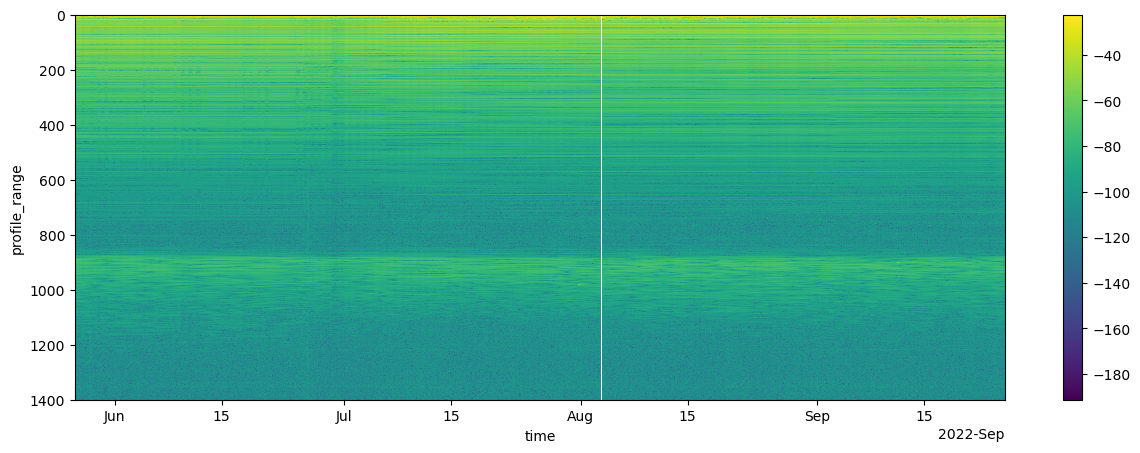

In [5]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(s22).plot(x='time')
ax.invert_yaxis()


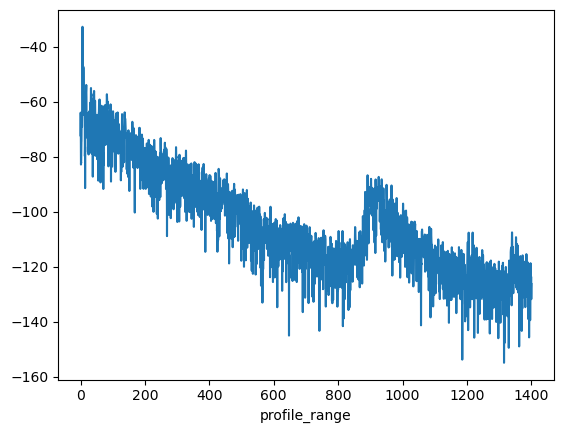

In [6]:
xa.dB(s22.mean(dim='time')).plot()


In [7]:
noise_floor_location = 800
for i in [20,30,40,60,70,80]:
    co_bins = s22.profile_range[::i].where(s22.profile_range[::i] <noise_floor_location,drop=True)
    print(f'Bin size of {i} points leads to a total of {len(co_bins)} points in the first {noise_floor_location} m')

Bin size of 20 points leads to a total of 172 points in the first 800 m
Bin size of 30 points leads to a total of 115 points in the first 800 m
Bin size of 40 points leads to a total of 86 points in the first 800 m
Bin size of 60 points leads to a total of 58 points in the first 800 m
Bin size of 70 points leads to a total of 49 points in the first 800 m
Bin size of 80 points leads to a total of 43 points in the first 800 m


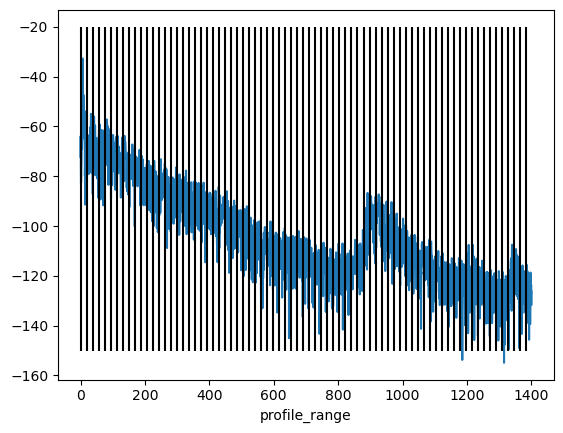

In [8]:
xa.dB(s22.mean(dim='time')).plot()
plt.vlines(s22.profile_range[::80].values,-150,-20,color='k')


80 seems to be the best choice here

In [9]:
time_to_interp = pd.date_range("2022-05-27 12:00", "2022-09-25 12:00", freq="15min")
interp_profiles = s22.interp(time=time_to_interp,method='linear')

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 2 -> frac high co 0.6, r2 0.32


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 4 -> frac high co 0.59, r2 0.44


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 8 -> frac high co 0.58, r2 0.57


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 24 -> frac high co 0.52, r2 0.74


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 48 -> frac high co 0.44, r2 0.83


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 96 -> frac high co 0.4, r2 0.9


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 192 -> frac high co 0.34, r2 0.94


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 288 -> frac high co 0.31, r2 0.97


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 672 -> frac high co 0.2, r2 0.96


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 1344 -> frac high co 0.085, r2 0.92


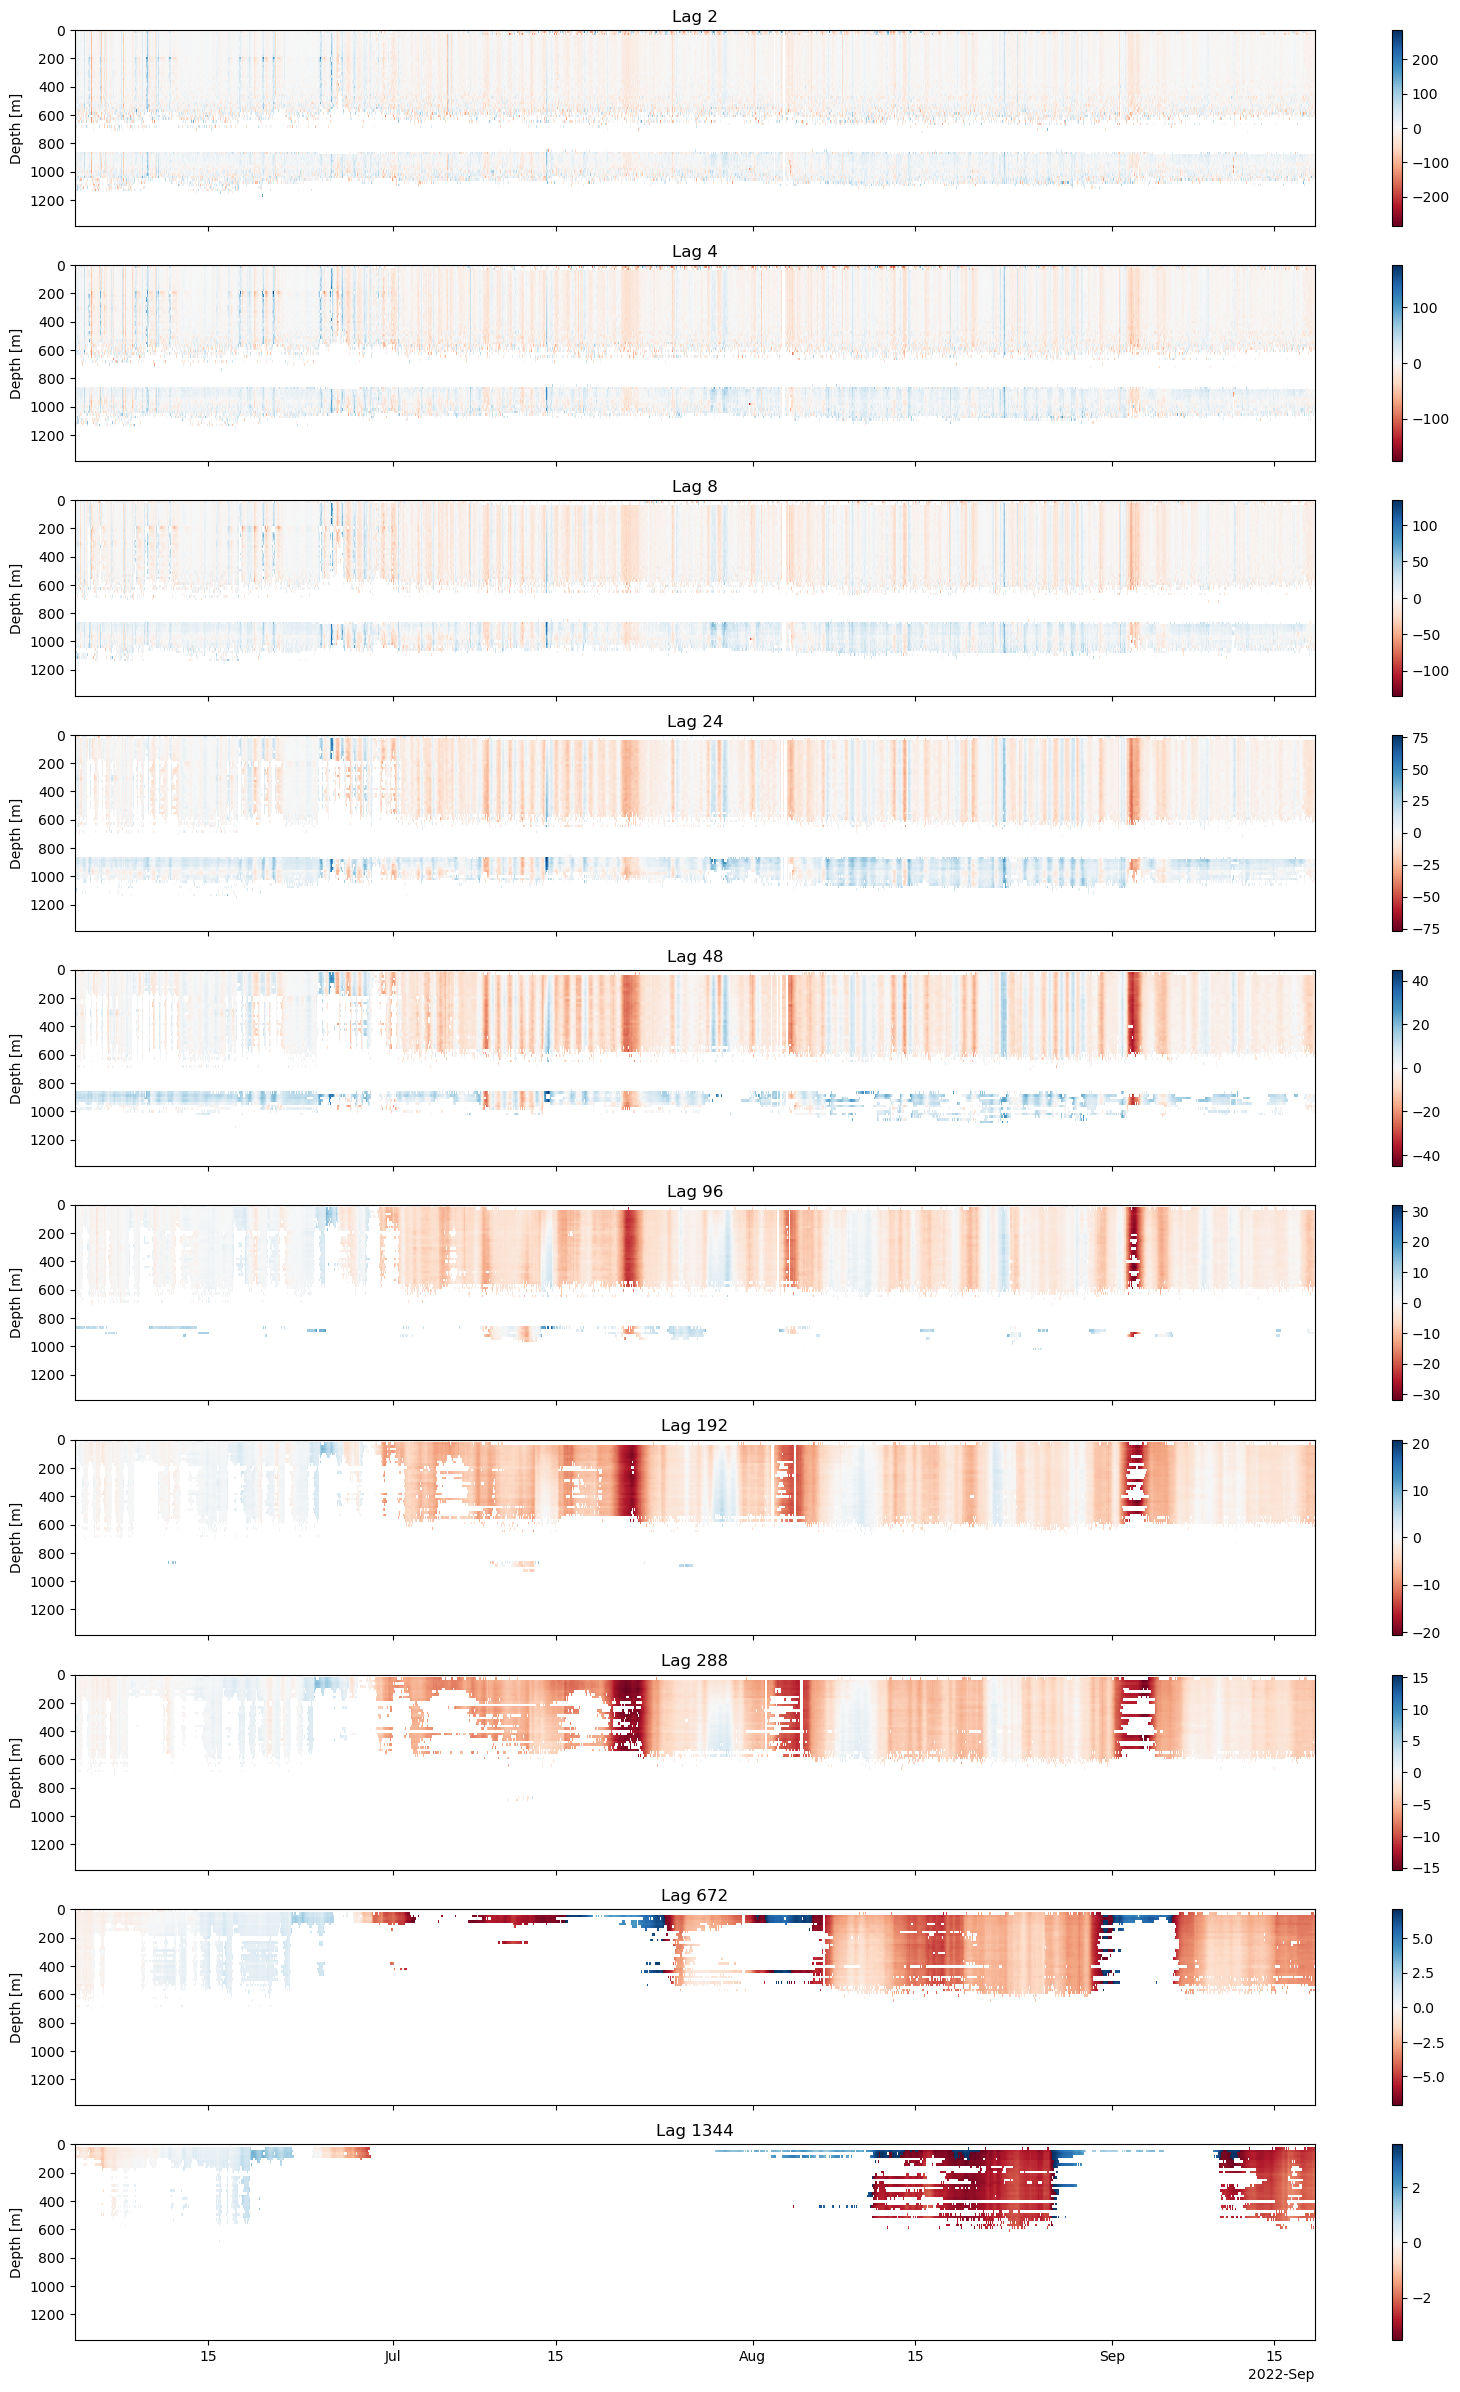

In [10]:
fig, axs = plt.subplots(figsize=(20,30),nrows=10,sharex=True)

for i in range(len(time_lags)):
    count,r2,res = strain_metrics(interp_profiles, 80, 80,time_lags[i],noise_floor_location)
    print(f"Lag {time_lags[i]} -> frac high co {count:.2}, r2 {r2:.2}")
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    plt1 = vv.plot(ax=axs[i],x='time',cmap='RdBu')#,vmin=-10,vmax=10)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('')
    axs[i].set_title(f"Lag {time_lags[i]}")
    #plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

In [11]:
count,r2,res = strain_metrics(interp_profiles, 80, 80,48,noise_floor_location)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


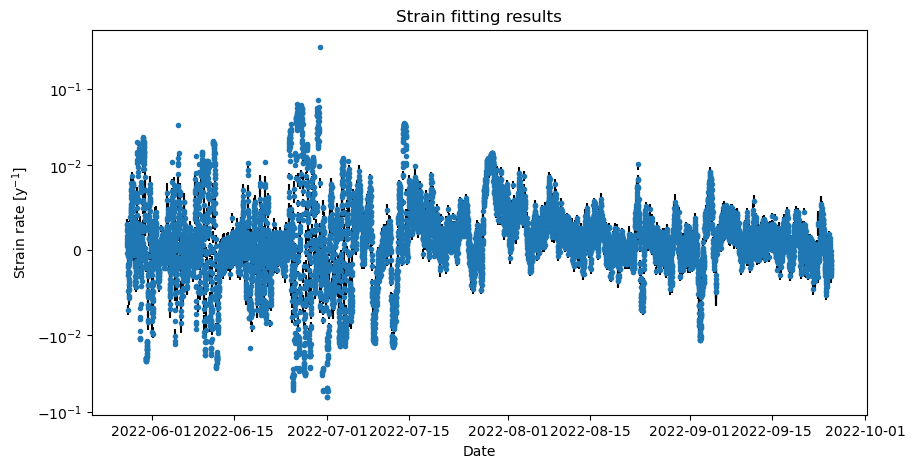

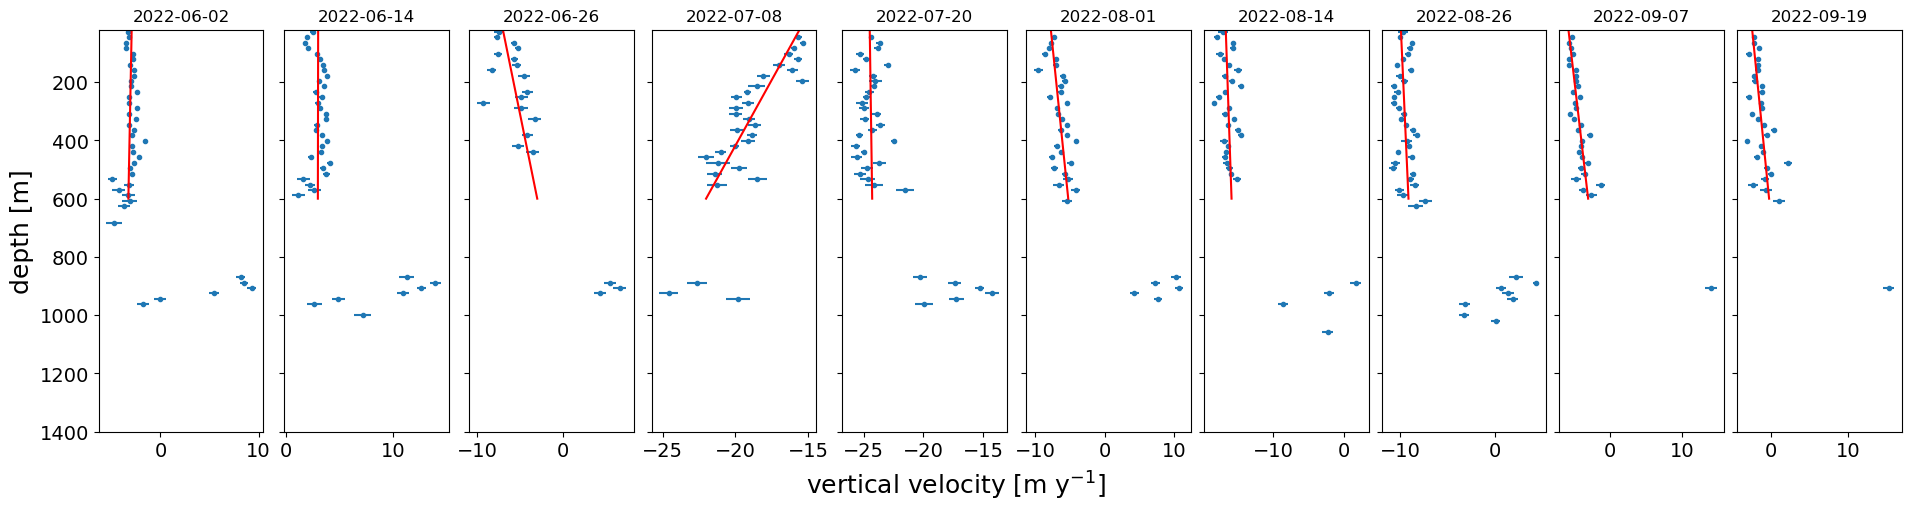

In [12]:
plot_strain_fit(res,xlims=None)#,ylims=[-1e-2,1e-2])

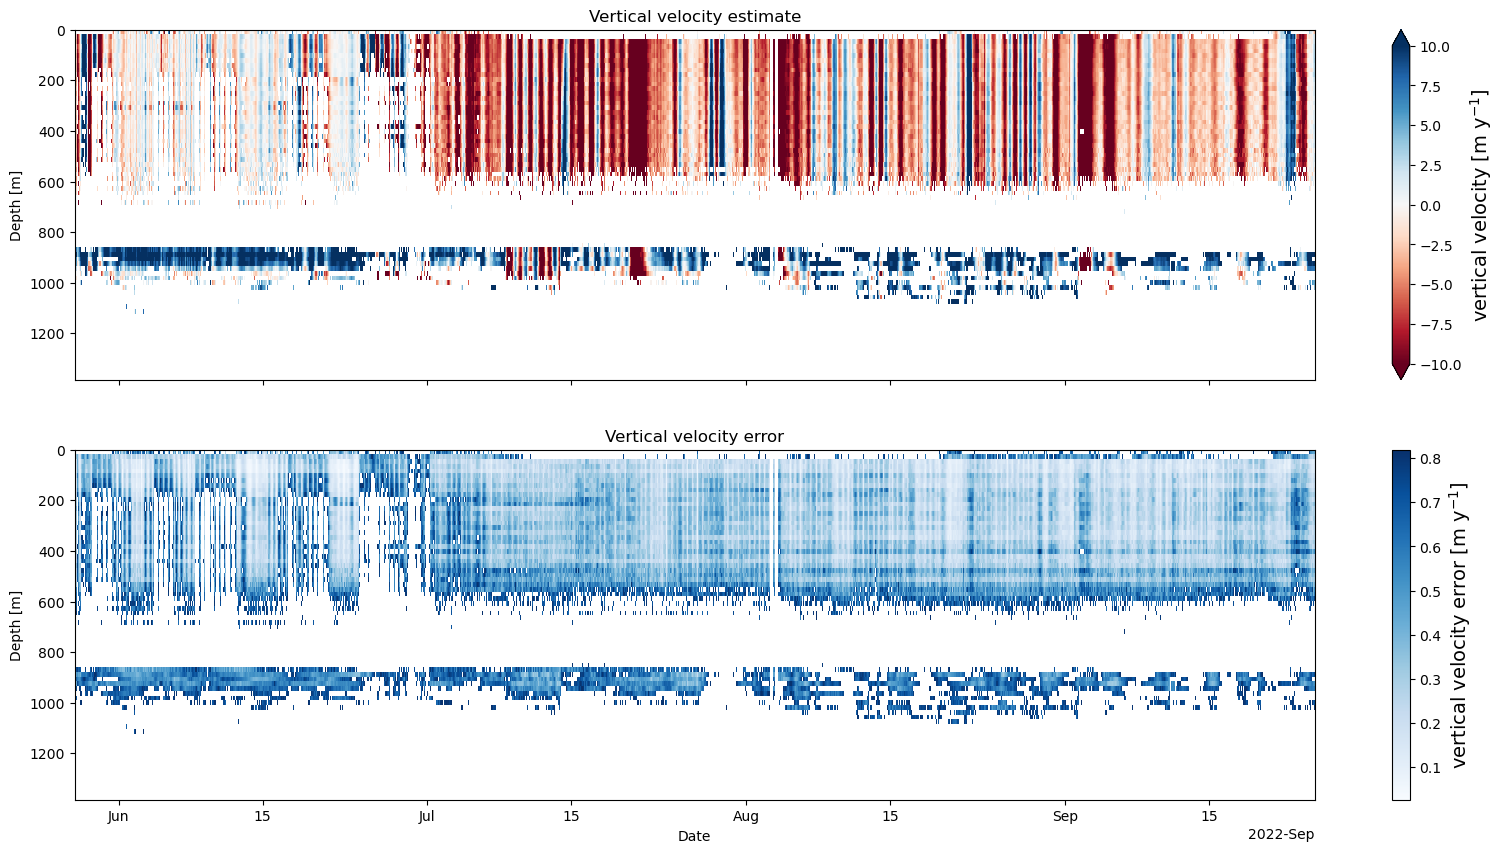

In [13]:
plot_vv_2d(res)

## A14 Winter

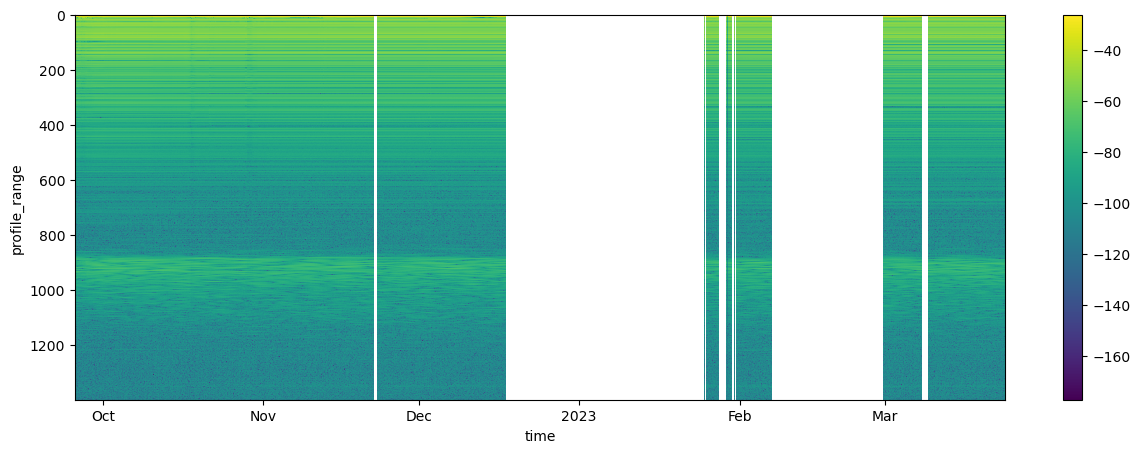

In [14]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(winter).plot(x='time')
ax.invert_yaxis()
#import datetime
#xlim=[datetime.date(2022, 12, 1), datetime.date(2023, 4, 1)]
#plt.xlim(xlim)

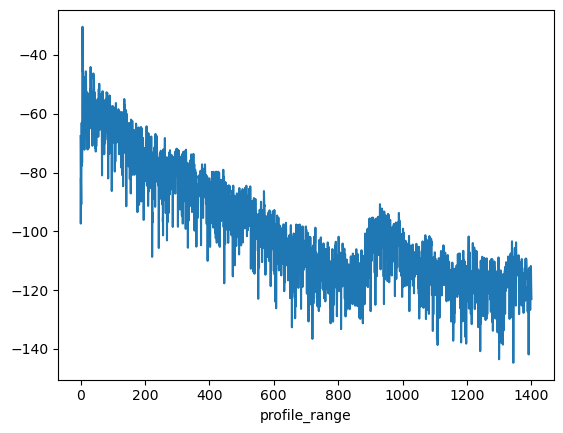

In [15]:
xa.dB(winter.mean(dim='time')).plot()


In [16]:
noise_floor_location = 800
for i in [20,30,40,60,70,80]:
    co_bins = winter.profile_range[::i].where(winter.profile_range[::i] <noise_floor_location,drop=True)
    print(f'Bin size of {i} points leads to a total of {len(co_bins)} points in the first {noise_floor_location} m')

Bin size of 20 points leads to a total of 190 points in the first 800 m
Bin size of 30 points leads to a total of 127 points in the first 800 m
Bin size of 40 points leads to a total of 95 points in the first 800 m
Bin size of 60 points leads to a total of 64 points in the first 800 m
Bin size of 70 points leads to a total of 55 points in the first 800 m
Bin size of 80 points leads to a total of 48 points in the first 800 m


Looks like 80 is the best window for the winter. Now for the time lag, we interpolate so we have consistent times.

In [17]:
time_to_interp = pd.date_range("2022-09-25 16:00", "2023-05-22 12:00", freq="15min")
interp_profiles = winter.interp(time=time_to_interp,method='linear')

Now we pick an optimal time lag. We do this by increasing it until we cannot see any bed estimate anymore, since that is the most evolving signal

In [18]:
time_lags = [2,4,8,24,48,96,192,288,672,1344] # 30 mins, 1,2,6,12 hours, 1,2,3 days, 1,2 weeks

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 2 -> frac high co 0.28, r2 0.096


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 4 -> frac high co 0.28, r2 0.11


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 8 -> frac high co 0.28, r2 0.14


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 24 -> frac high co 0.27, r2 0.2


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 48 -> frac high co 0.24, r2 0.26


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 96 -> frac high co 0.21, r2 0.29


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 192 -> frac high co 0.19, r2 0.37


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 288 -> frac high co 0.19, r2 0.43


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 672 -> frac high co 0.17, r2 0.58


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 1344 -> frac high co 0.14, r2 0.67


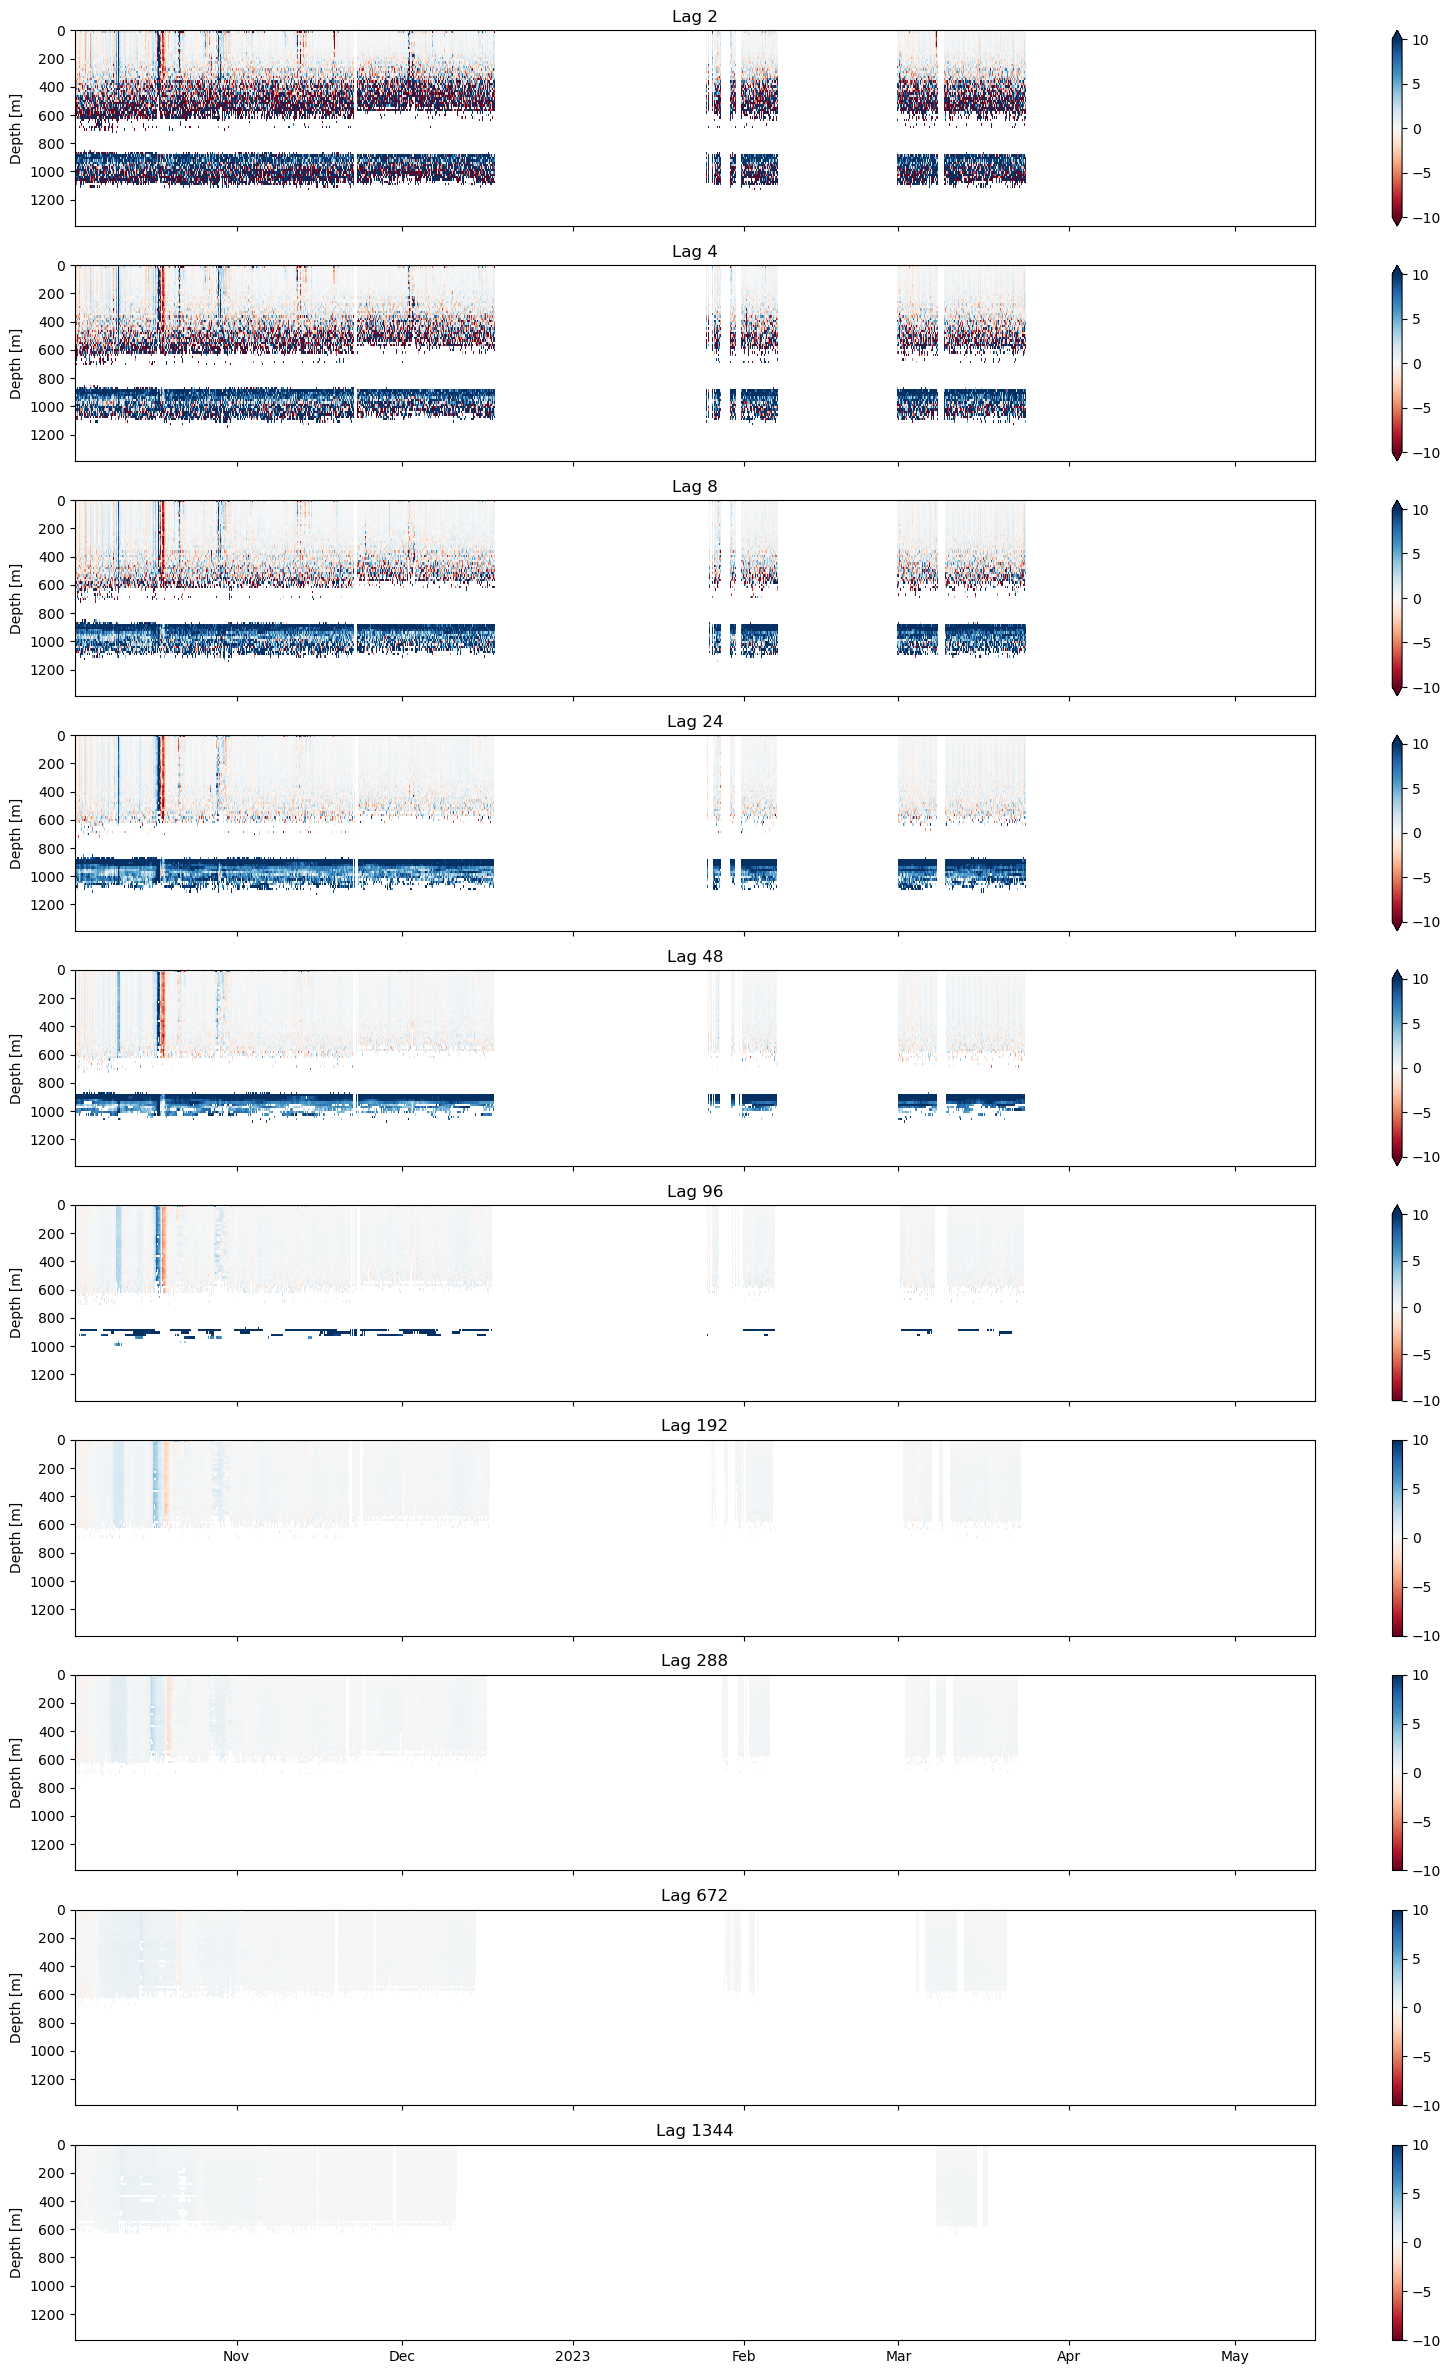

In [19]:
fig, axs = plt.subplots(figsize=(20,30),nrows=10,sharex=True)

for i in range(len(time_lags)):
    count,r2,res = strain_metrics(interp_profiles, 80, 80,time_lags[i],noise_floor_location)
    print(f"Lag {time_lags[i]} -> frac high co {count:.2}, r2 {r2:.2}")
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    plt1 = vv.plot(ax=axs[i],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('')
    axs[i].set_title(f"Lag {time_lags[i]}")
    #plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

Looks like a 12 hour vertical velocity works best

In [20]:
count,r2,res = strain_metrics(interp_profiles, 80, 80,48,noise_floor_location)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


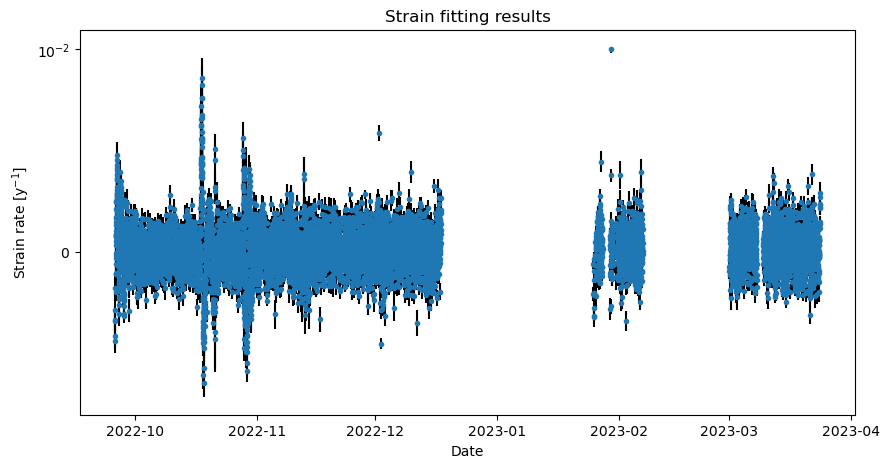

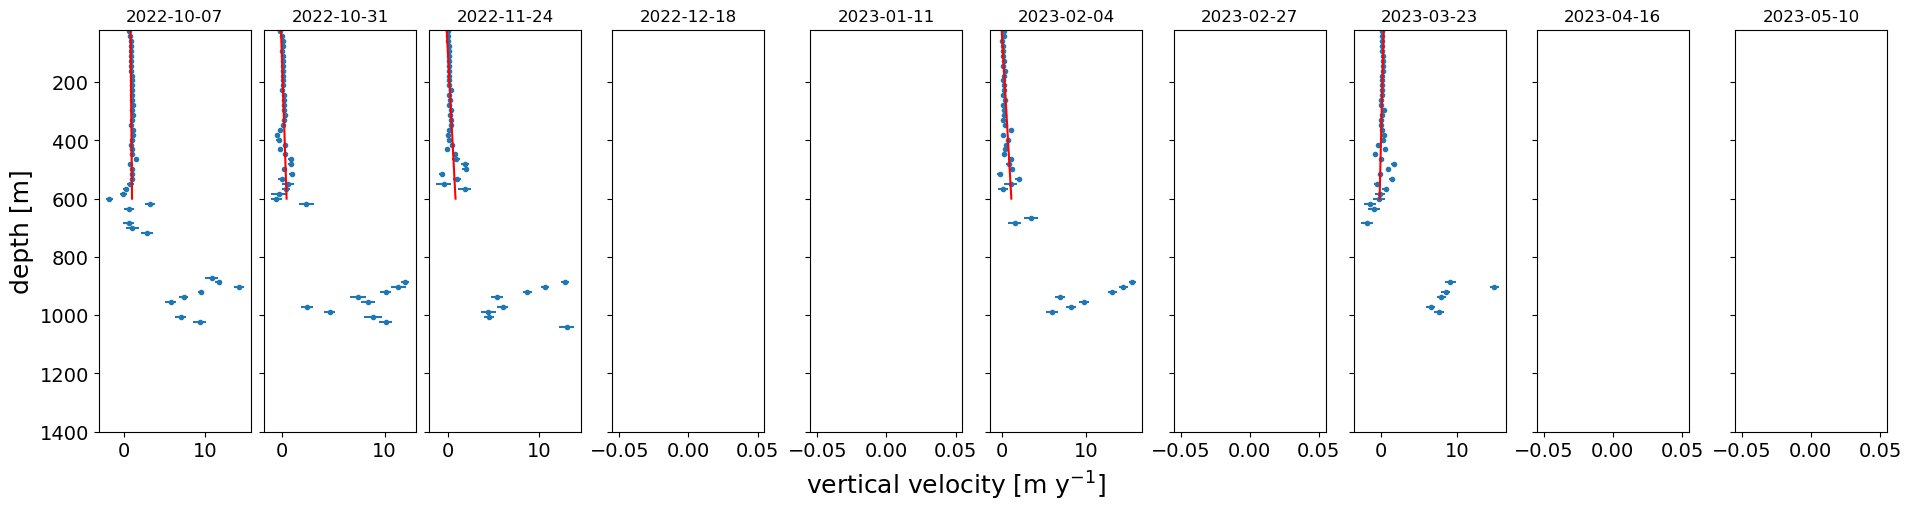

In [21]:
plot_strain_fit(res)

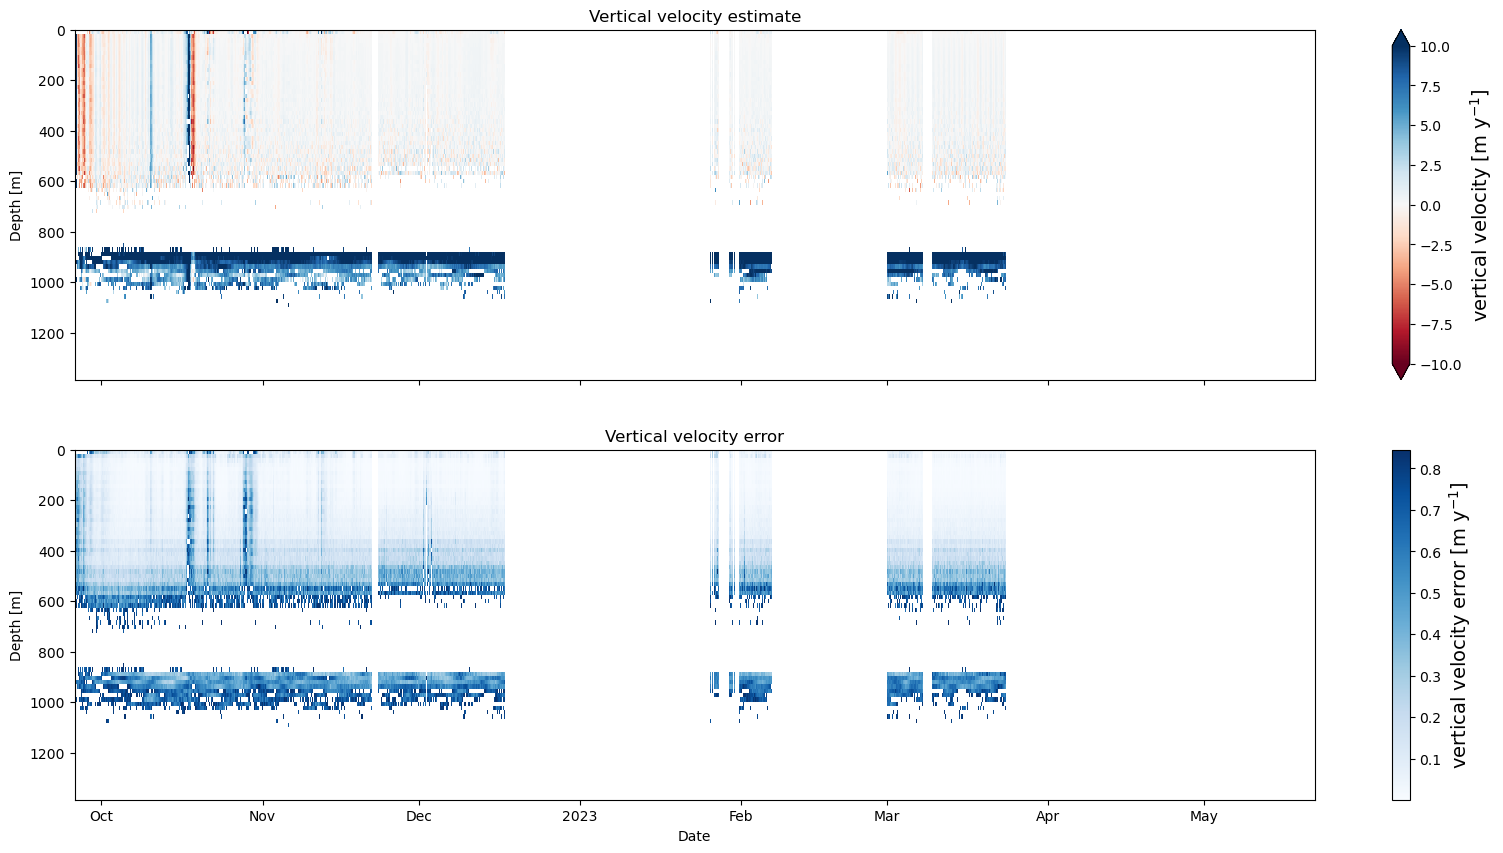

In [22]:
plot_vv_2d(res)

## A14 Summer 2023

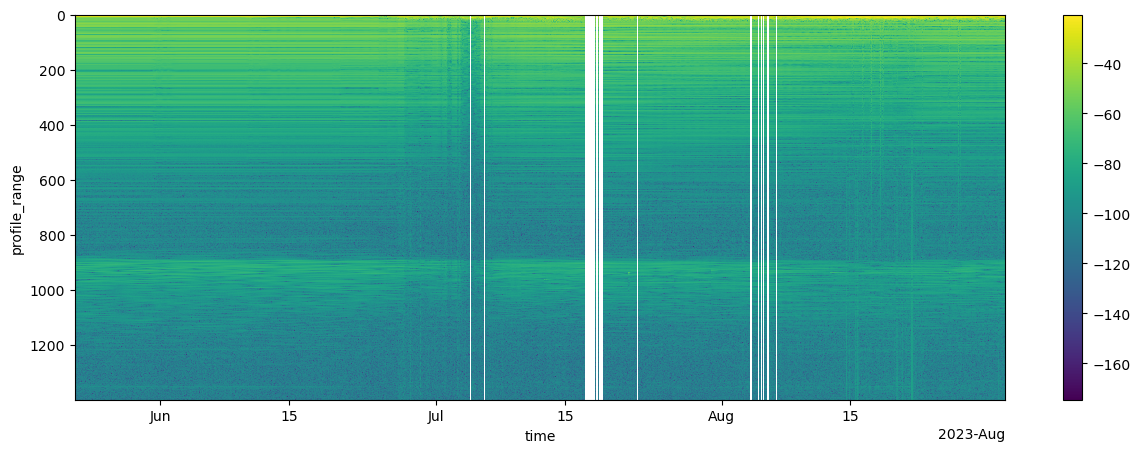

In [23]:
fig, ax = plt.subplots(figsize=(15,5))
xa.dB(s23).plot(x='time')
ax.invert_yaxis()


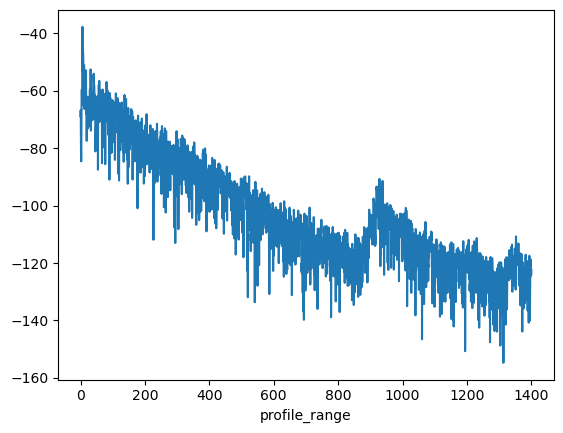

In [24]:
xa.dB(s23.mean(dim='time')).plot()


In [25]:
noise_floor_location = 800
for i in [20,30,40,50,60,70,80]:
    co_bins = s23.profile_range[::i].where(s23.profile_range[::i] <noise_floor_location,drop=True)
    print(f'Bin size of {i} points leads to a total of {len(co_bins)} points in the first {noise_floor_location} m')

Bin size of 20 points leads to a total of 153 points in the first 800 m
Bin size of 30 points leads to a total of 102 points in the first 800 m
Bin size of 40 points leads to a total of 77 points in the first 800 m
Bin size of 50 points leads to a total of 61 points in the first 800 m
Bin size of 60 points leads to a total of 51 points in the first 800 m
Bin size of 70 points leads to a total of 44 points in the first 800 m
Bin size of 80 points leads to a total of 39 points in the first 800 m


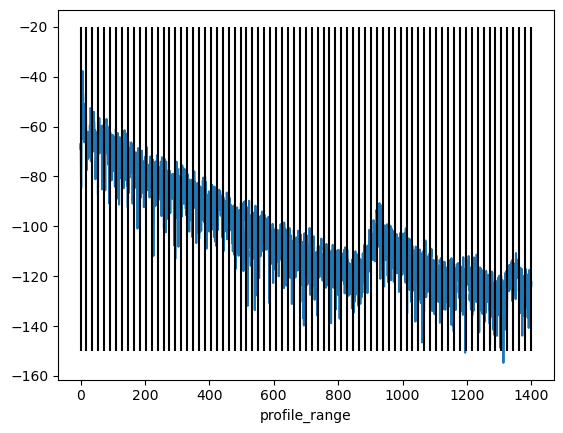

In [26]:
xa.dB(s23.mean(dim='time')).plot()
plt.vlines(s23.profile_range[::70].values,-150,-20,color='k')


70 seems to be the best choice here

In [27]:
time_to_interp = pd.date_range("2023-05-20 12:00", "2023-08-31 12:00", freq="15min")
interp_profiles = s23.interp(time=time_to_interp,method='linear')

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 2 -> frac high co 0.53, r2 0.28


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 4 -> frac high co 0.51, r2 0.38


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 8 -> frac high co 0.48, r2 0.52


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 24 -> frac high co 0.41, r2 0.75


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 48 -> frac high co 0.35, r2 0.84


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 96 -> frac high co 0.31, r2 0.91


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 192 -> frac high co 0.25, r2 0.95


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 288 -> frac high co 0.21, r2 0.97


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 672 -> frac high co 0.12, r2 0.67


/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


Lag 1344 -> frac high co 0.089, r2 0.58


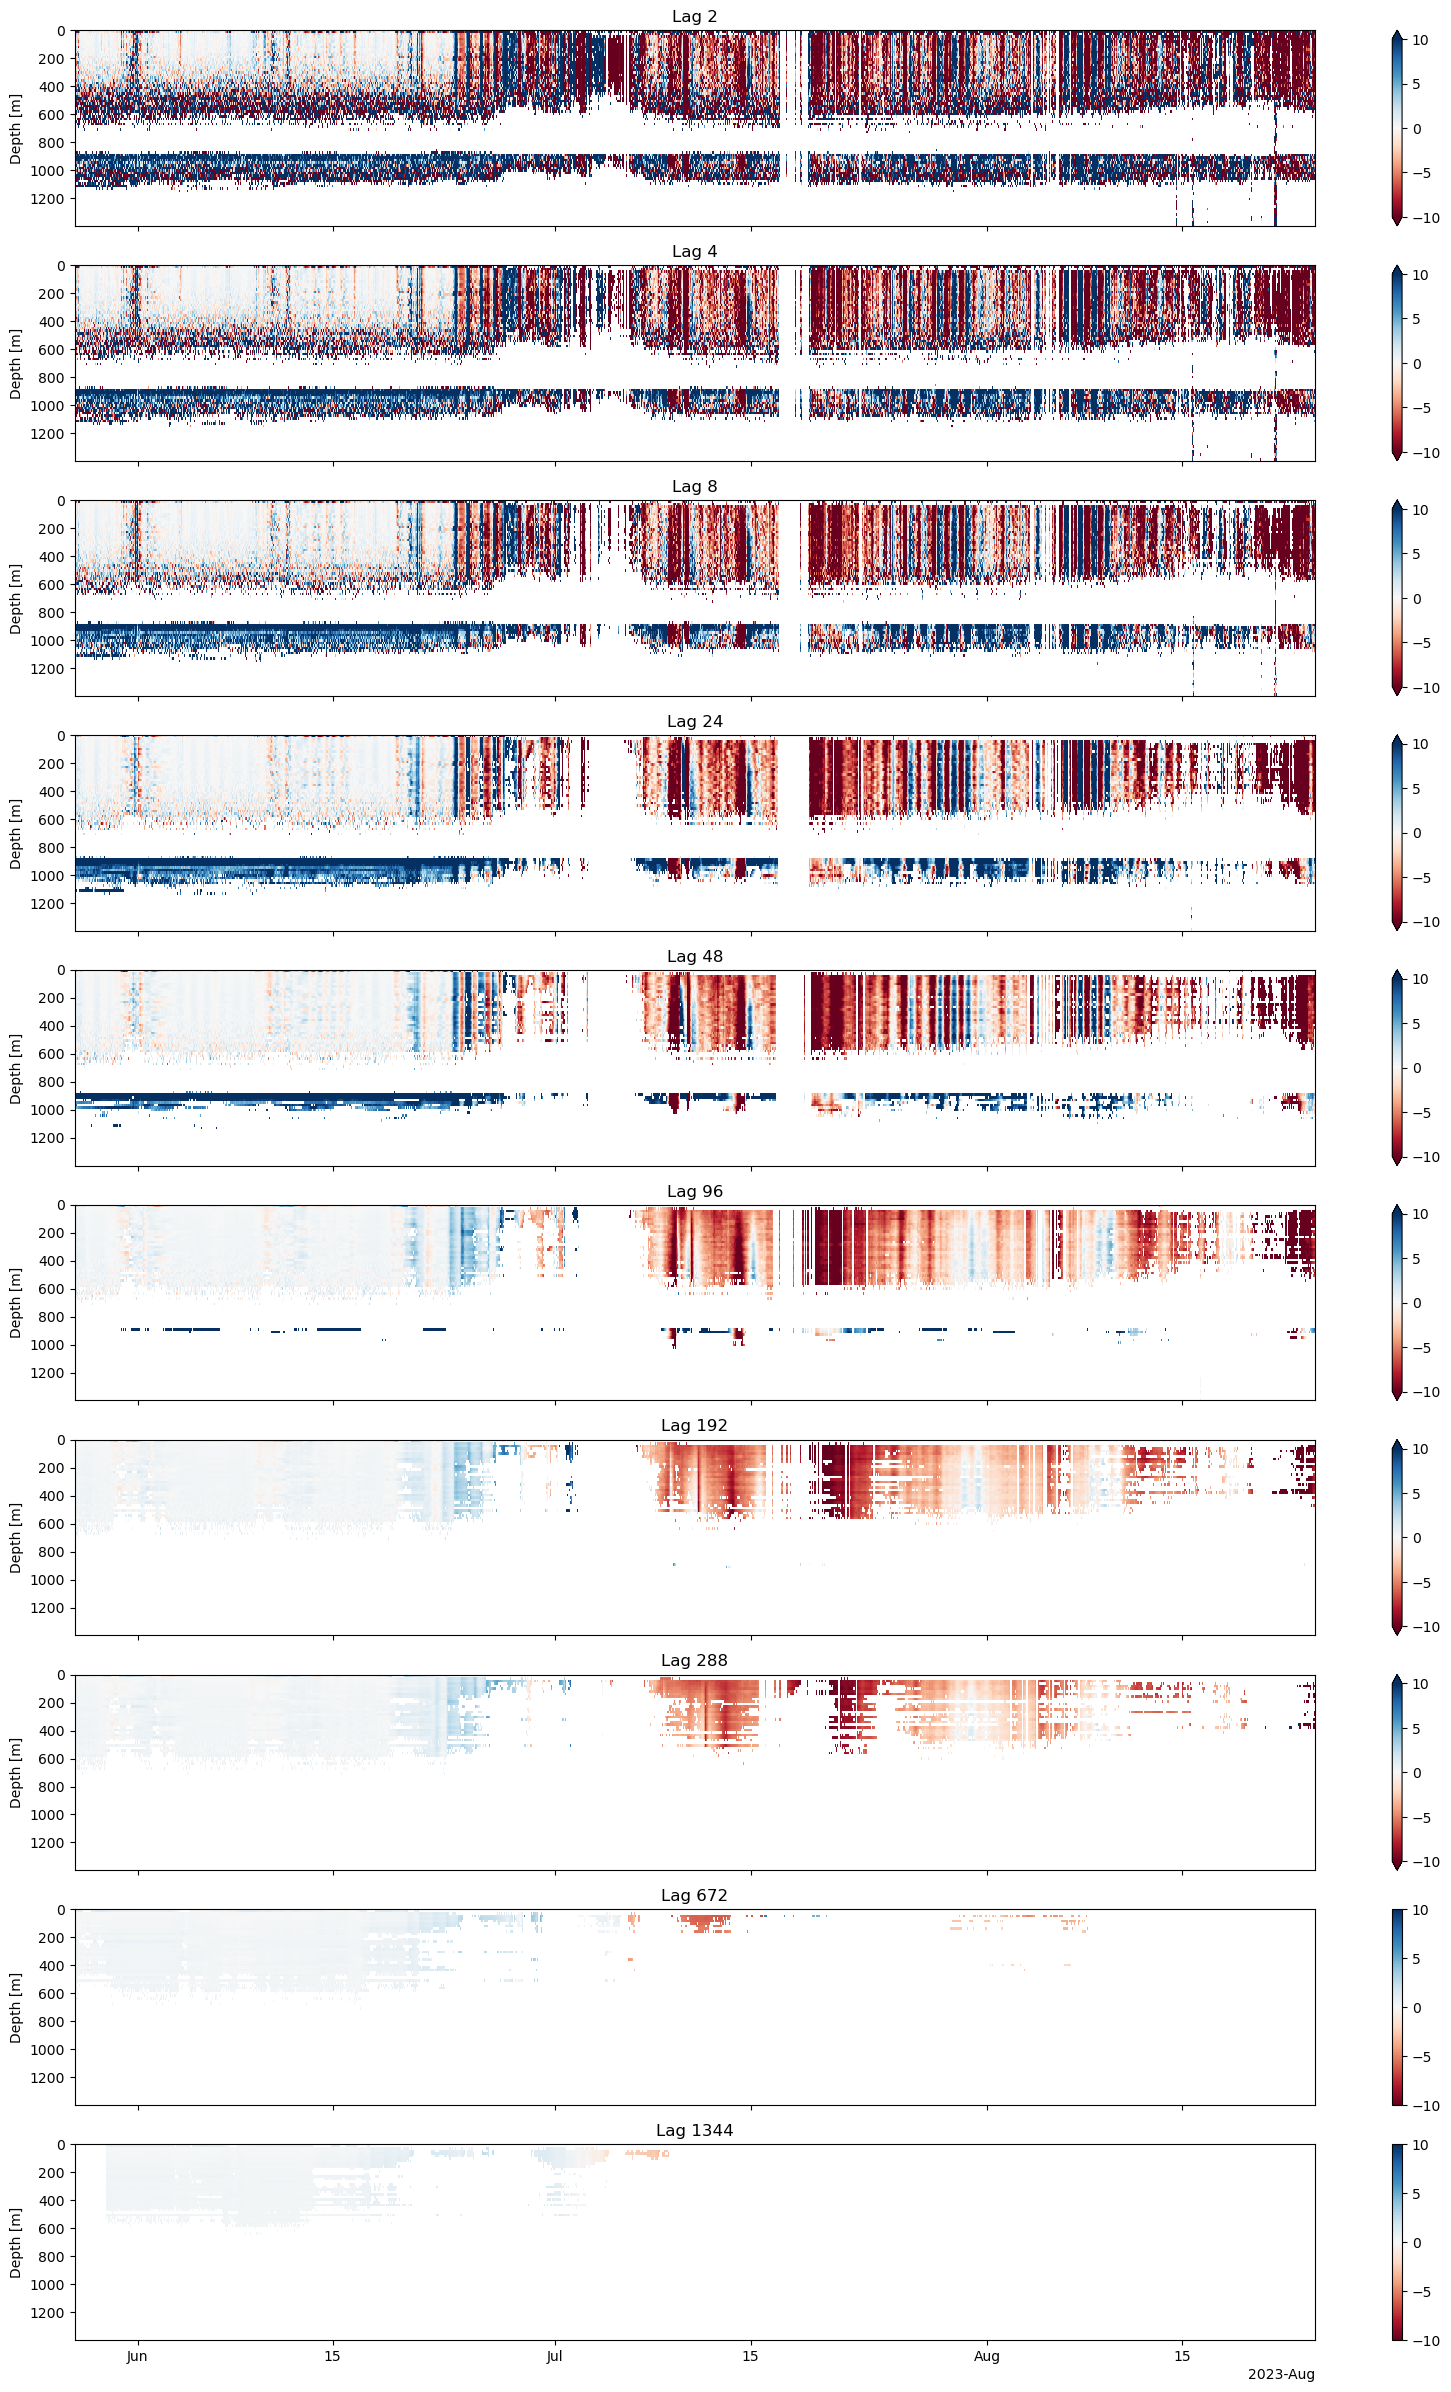

In [28]:
fig, axs = plt.subplots(figsize=(20,30),nrows=10,sharex=True)

for i in range(len(time_lags)):
    count,r2,res = strain_metrics(interp_profiles, 70, 70,time_lags[i],noise_floor_location)
    print(f"Lag {time_lags[i]} -> frac high co {count:.2}, r2 {r2:.2}")
    vv = res[0]
    vv_err = res[1]
    fit=res[2]
    r2 = res[3]
    plt1 = vv.plot(ax=axs[i],x='time',cmap='RdBu',vmin=-10,vmax=10)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('')
    axs[i].set_title(f"Lag {time_lags[i]}")
    #plt1.colorbar.set_label(label='vertical velocity [m y$^{-1}$]', size=14)

In [29]:
count,r2,res = strain_metrics(interp_profiles, 70, 70,48,noise_floor_location)

/home/jovyan/xapres_package/notebooks/test_notes/strain_rates/../../../xapres_package/ApRESDefs.py:654: RuntimeWarning: invalid value encountered in divide
  c = top/bottom


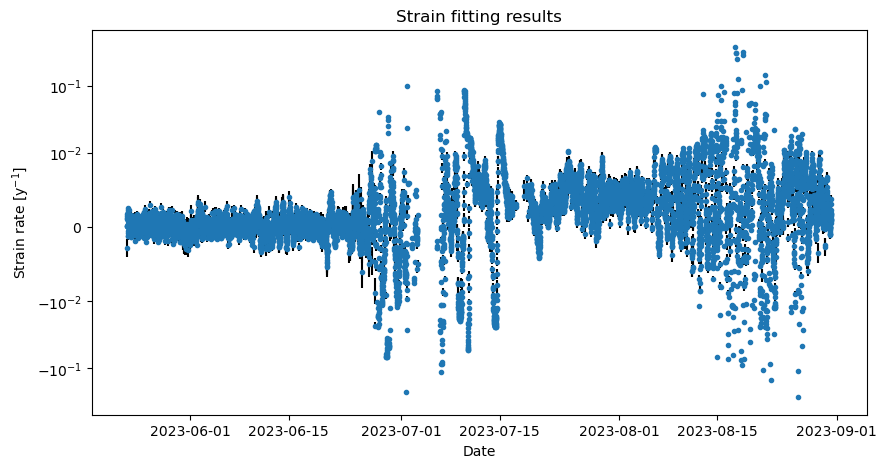

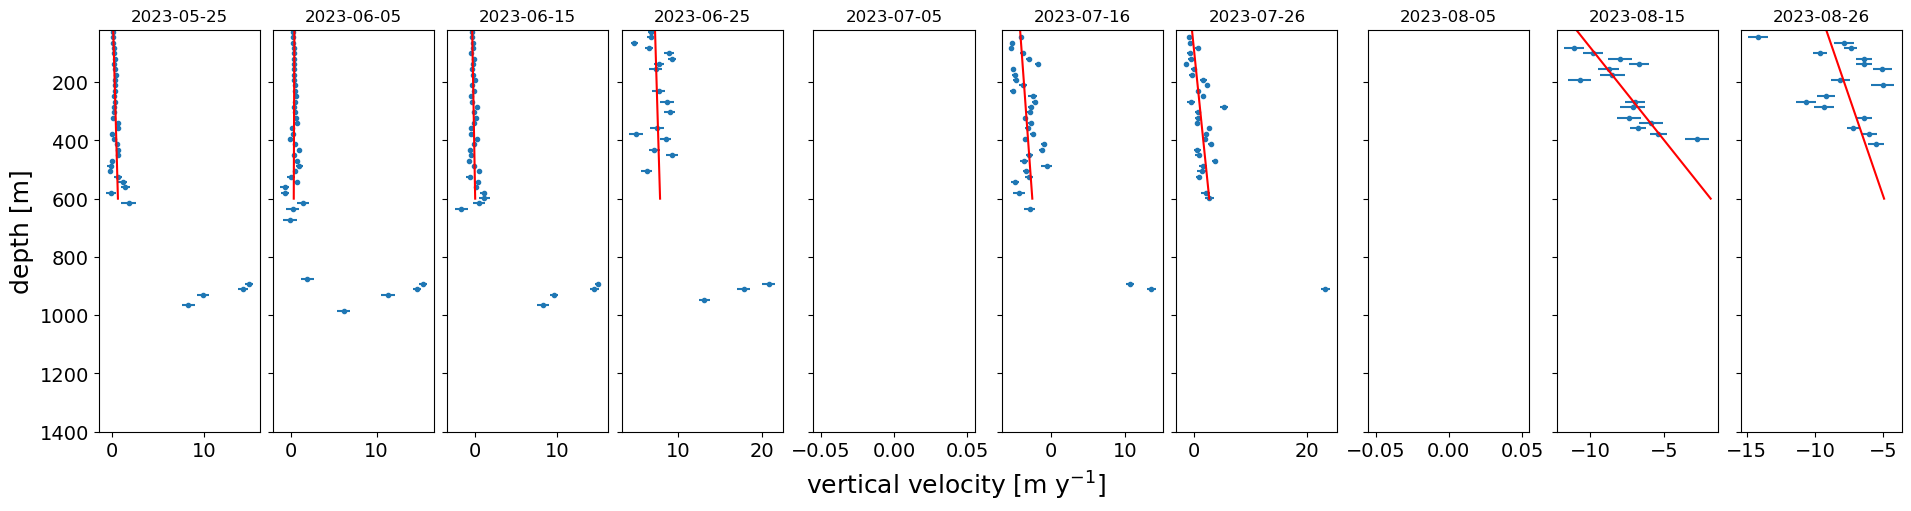

In [30]:
plot_strain_fit(res,xlims=None)#,ylims=[-1e-2,1e-2])

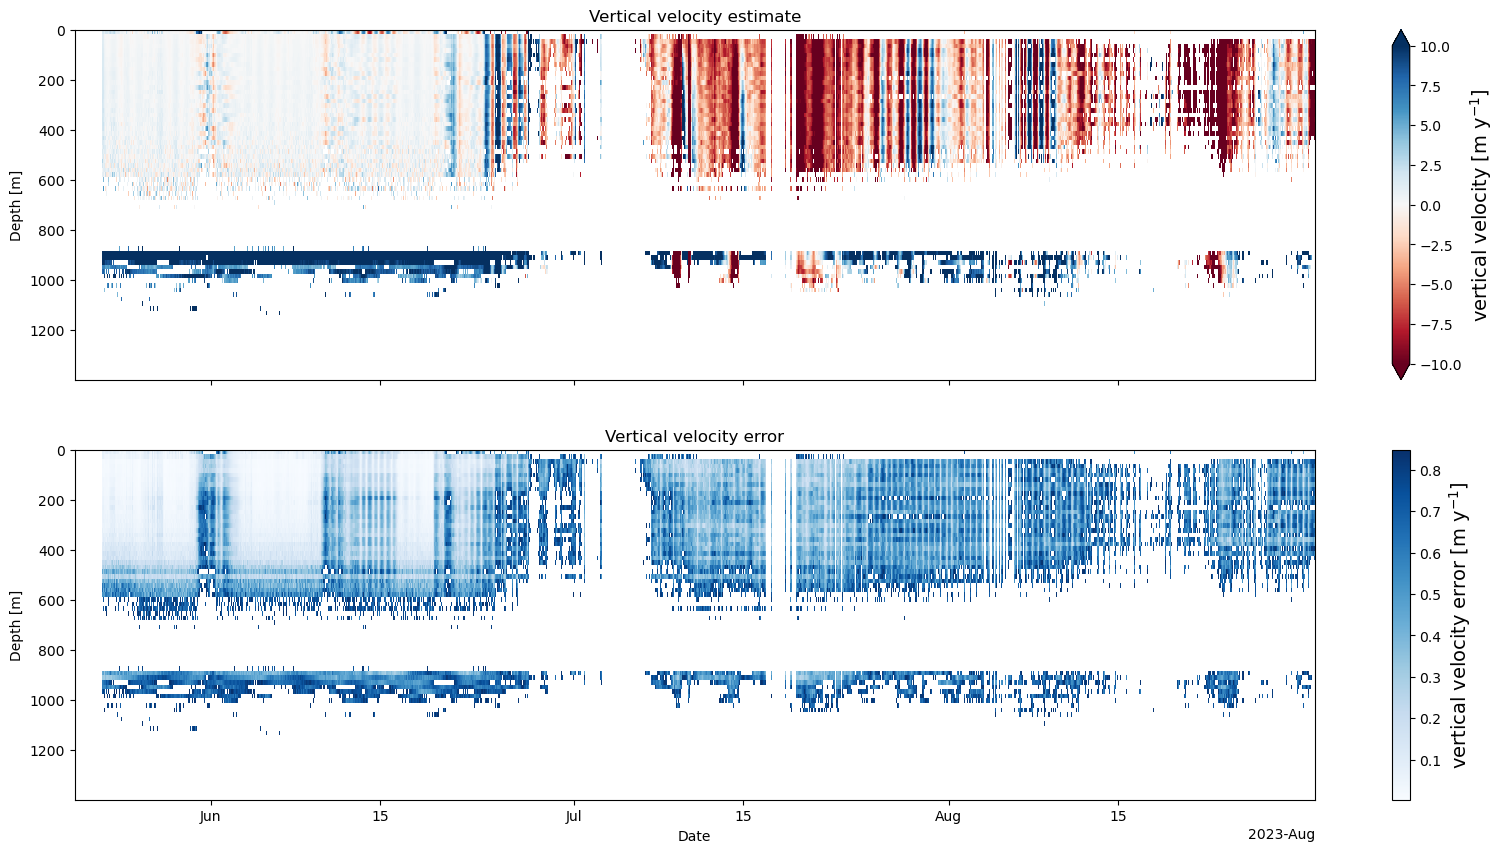

In [31]:
plot_vv_2d(res)